# Data Profiling

## Connect to data

In [3]:
import pymysql.cursors
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sqlalchemy import create_engine
import re
import operator

In [9]:
server = "localhost"
user = "student"
pwd = "student"
db = "4iz562"
port = 3308

## Toolkit

### Query to Data Frame

In [13]:
def query(sql):
    engine = create_engine('mysql+pymysql://'+user+':'+pwd+'@'+server+':'+str(port)+'/'+db)
    connection = engine.connect()
    result = connection.execute(sql)
    table = DataFrame(result.fetchall())
    table.columns = result.keys()
    connection.close()
    engine.dispose()
    return table

### Statistics and plotting

In [11]:
def statistics(df):
    
    y = df.dropna().tolist()
    D = np.fromiter(y, dtype=float, count=-1)
    
    print('Count: '+str(df.count()))
    print('Not null: '+str(df.dropna().count()))
    print('Unique: '+str(df.nunique(dropna=True)))
    print('Duplicated: '+str(df.duplicated().count()))
    
    print('Min: '+str(df.min()))
    print('Max: '+str(df.max()))
    print('Mean abs. dev.: '+str(df.mad()))
    #print('Mode: '+str(df.mode()[1]))
    print('Median: '+str(df.median()))
    print('Mean: '+str(df.mean()))
    print('75% Quantile: '+str(df.quantile(q=0.75)))
    
    print('Kurtosis: '+str(df.kurtosis()))
    print('Skeweness: '+str(df.skew()))
    
    print('Std Dev: '+str(df.std()))
    print('Variance: '+str(df.var()))
    
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)

    plt.boxplot(D, 1, 'gD')
    plt.hlines(15, xmin=0, xmax=2, colors='gray')
    plt.hlines(100, xmin=0, xmax=2, colors='gray')
    
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    
    plt.hist(D, bins=80, color='gray', edgecolor='white')
    plt.show()

## Party Age analysis

In [14]:
df = query("select cast(PARTY_AGE as signed) as PARTY_AGE from PART_PARTY where PARTY_TYPE = 'P'")
df.head()
df.size

263783

In [15]:
df.count()

PARTY_AGE    261101
dtype: int64

In [16]:
df.describe()

,PARTY_AGE
count,261101.000000
mean,45.661208
std,18.499126
min,15.000000
25%,30.000000
50%,44.000000
75%,60.000000
max,98.000000


... there must be some not NULL missing values

Count: 261101
Not null: 261101
Unique: 84
Duplicated: 263783
Min: 15.0
Max: 98.0
Mean abs. dev.: 15.755938261133432
Median: 44.0
Mean: 45.66120773187387
75% Quantile: 60.0
Kurtosis: -0.8707787937978901
Skeweness: 0.25993857108666857
Std Dev: 18.499125588737677
Variance: 342.21764754788904


/tmp/ipykernel_182221/69975354.py:13: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  print('Mean abs. dev.: '+str(df.mad()))


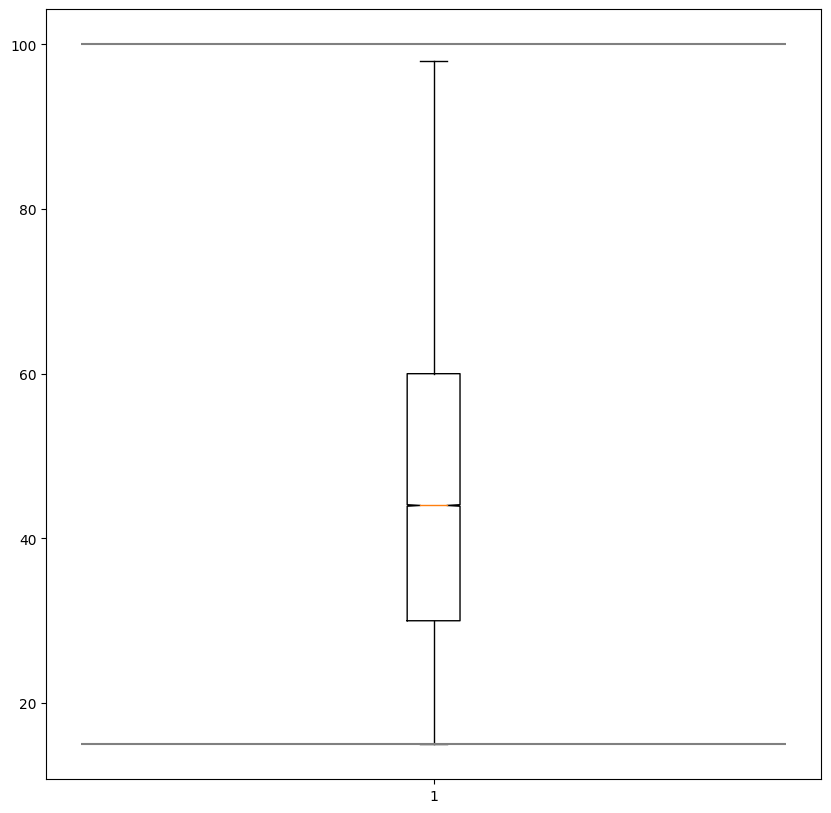

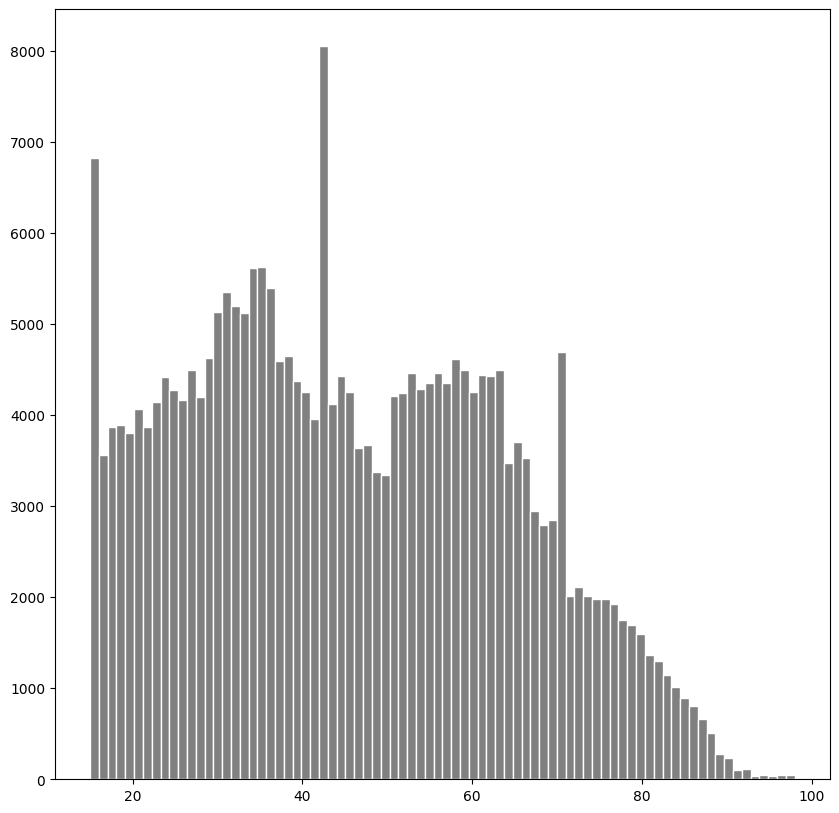

In [17]:
statistics(df['PARTY_AGE'])

## Age vs. empirical age

In [18]:
df = query("select cast(PARTY_AGE as signed) as PARTY_AGE, TIMESTAMPDIFF(YEAR, PARTY_DOFBIRTH, CURDATE()) as REAL_AGE from PART_PARTY where PARTY_TYPE = 'P'").dropna()
df.head()

,PARTY_AGE,REAL_AGE
0,80.0,90.0
1,80.0,90.0
2,80.0,90.0
3,80.0,90.0
4,80.0,90.0


### Distribution age vs. empirical age

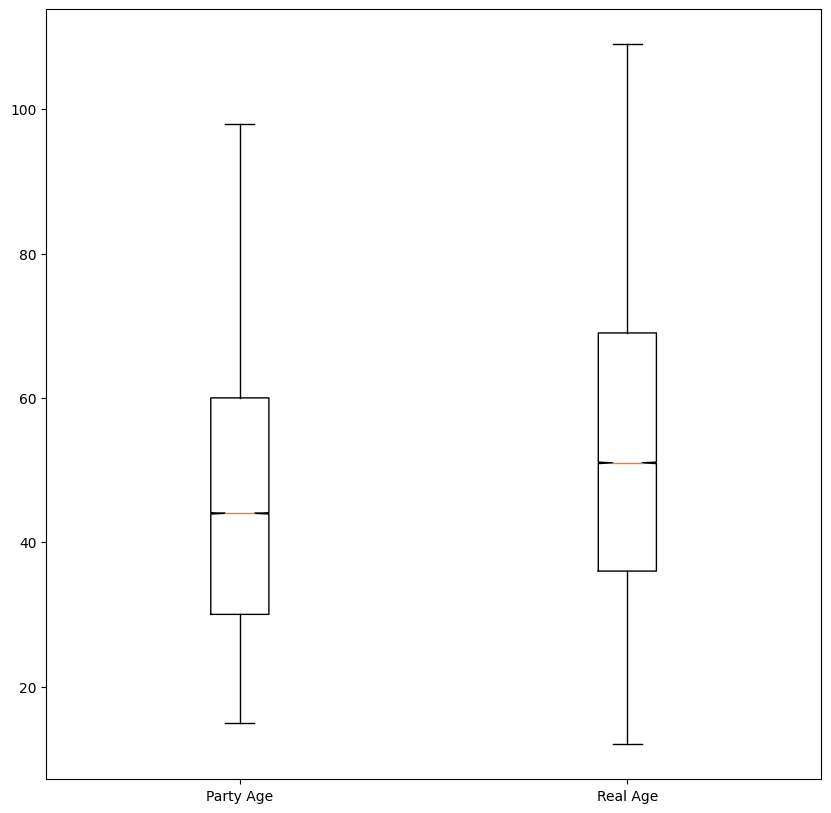

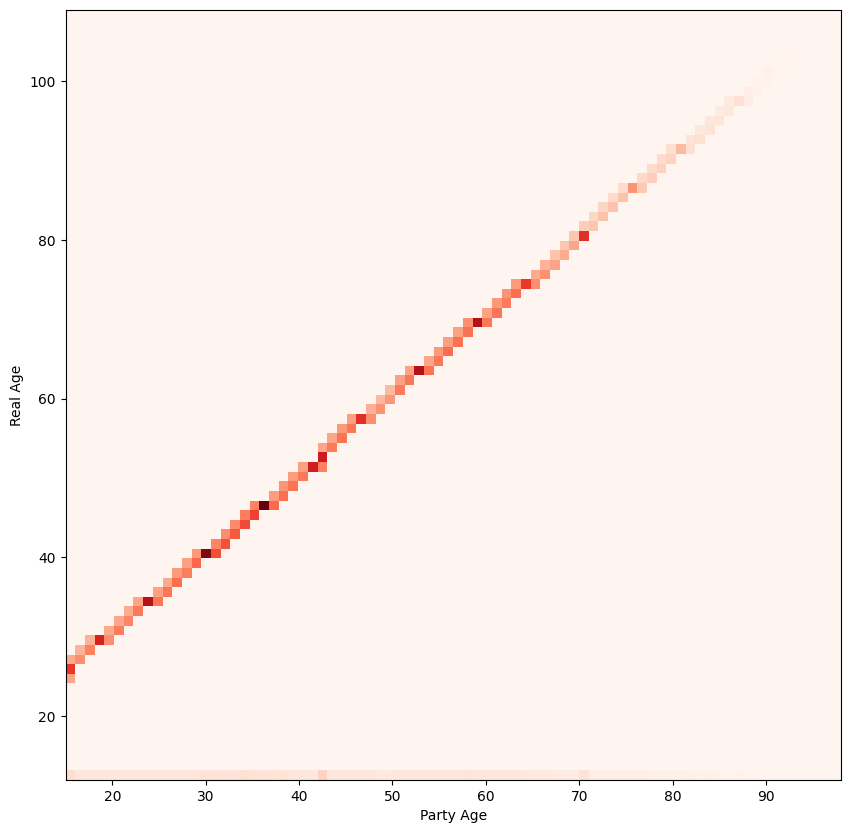

In [19]:
X1 = np.fromiter(df['PARTY_AGE'].dropna().tolist(), dtype=float, count=-1)
X2 = np.fromiter(df['REAL_AGE'].dropna().tolist(), dtype=float, count=-1)
    
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.boxplot([X1,X2], 1, 'gD', labels=['Party Age','Real Age'])

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.hist2d(df['PARTY_AGE'], df['REAL_AGE'], bins=(80, 80), cmap=plt.cm.Reds)
plt.xlabel('Party Age')
plt.ylabel('Real Age')

plt.show()

## Demographic tree

In [21]:
import seaborn as sns
import pandas as pd

In [22]:
df = query("select TIMESTAMPDIFF(YEAR, PARTY_DOFBIRTH, CURDATE()) as REAL_AGE, PARTY_GENDER  from PART_PARTY where PARTY_TYPE = 'P'")
df.head()

,REAL_AGE,PARTY_GENDER
0,90.0,F
1,90.0,M
2,90.0,F
3,90.0,F
4,90.0,F


In [23]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,150]
labels = ['0-5','5-10','10-15','15-20','20-25',
          '25-30','30-35','35-40','40-45','45-50',
          '50-55','55-60','60-65','65-70','70-75',
          '75-80','80-85','85-90','90-95','95-100','100+']

In [24]:
df['Age'] = pd.cut(df['REAL_AGE'], bins=bins, labels=labels, right=False)

In [25]:
df.head()

,REAL_AGE,PARTY_GENDER,Age
0,90.0,F,90-95
1,90.0,M,90-95
2,90.0,F,90-95
3,90.0,F,90-95
4,90.0,F,90-95


In [26]:
dfm = df[df['PARTY_GENDER'] == 'M'].groupby('Age').sum().reset_index().rename(columns={'REAL_AGE':'Males'})
dff = df[df['PARTY_GENDER'] == 'F'].groupby('Age').sum().reset_index().rename(columns={'REAL_AGE':'Females'})

/tmp/ipykernel_182221/1943703740.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfm = df[df['PARTY_GENDER'] == 'M'].groupby('Age').sum().reset_index().rename(columns={'REAL_AGE':'Males'})
/tmp/ipykernel_182221/1943703740.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dff = df[df['PARTY_GENDER'] == 'F'].groupby('Age').sum().reset_index().rename(columns={'REAL_AGE':'Females'})


In [27]:
dfm['Males'] = dfm['Males'] * (-1)
dfm.head()

,Age,Males
0,0-5,-0.0
1,5-10,-0.0
2,10-15,-131650.0
3,15-20,-0.0
4,20-25,-0.0


In [28]:
dfr = dfm.merge(dff, on='Age')

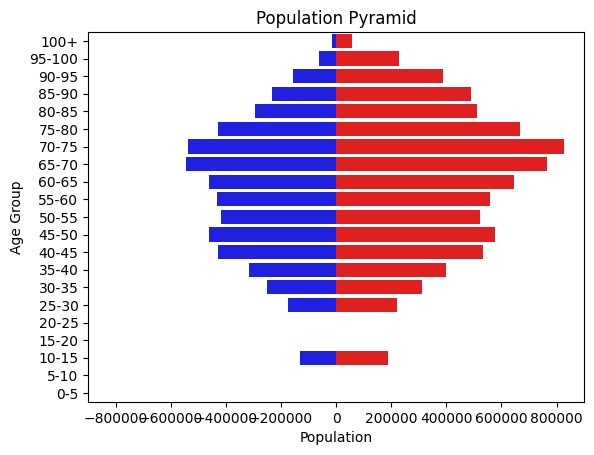

In [29]:
bar_plot = sns.barplot(x='Males', y='Age', data=dfr, color='blue')
bar_plot = sns.barplot(x='Females', y='Age', data=dfr, color='red')
bar_plot.set(xlabel='Population', ylabel='Age Group', title='Population Pyramid', xlim=(-900000, 900000))
sns.set(rc={'figure.figsize': (10,8)})
bar_plot.invert_yaxis()

### Some useful functions

#### Frequency Analysis

In [30]:
def countBy(key, by, src):
    return src.loc[:,[key,by]].groupby(by).count()

#### Pattern Encoding

In [31]:
def encodePattern(src):
    out = re.sub(r'[a-zěščřžýáíéůú]', r'a', str(src))
    out = re.sub(r'[A-ZĚŠČŘŽÝÁÍÉŮÚ]', r'A', str(out))
    out = re.sub(r'[0-9]', r'9', str(out))
    out = re.sub(r'[-,/.*]', r'*', str(out))
    out = re.sub(r'[\s]', r'#', str(out))
    return out

In [32]:
def getPatterns(attrib, res):
    d = dict()
    for i in res[attrib]:
        x = encodePattern(i)
        if x in d:
            d[x] += 1
        else:
            d[x] = 1
    desc = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    asc = sorted(d.items(), key=operator.itemgetter(1),reverse=False)
    return asc, desc

## Profilace adres

In [33]:
# load adres z MySQL
res = query('select * from PARTY_ADDRESS')

In [34]:
# test encodePattern
encodePattern('Vinohradská 583/120a')

'Aaaaaaaaaaa#999*999a'

In [36]:
import sys
print(sys.getsizeof(res) / 1024 / 1024)

562.3329362869263


In [38]:
res.head()

,ADDR_ID,PARTY_ID,ADDR_TYPE,ADDR_COUNTRY,ADDR_CITY,ADDR_STREET,ADDR_NUM1,ADDR_NUM2,ADDR_ZIP,DQM_VALID_SCORE,DQM_VALID_CODE,DQM_ERR
0,1,38569,C,CZE,Dobruška,Na Budíně 854,None,None,51801,0.00,000000000,None
1,2,292510,C,CZE,Dobruška,Na Budíně 854,None,None,51801,0.00,000000000,None
2,3,38570,C,CZE,Plzeň - Jižní Předměstí,U Svépomoci 1708/10,None,None,30100,0.00,000000000,None
3,4,183048,C,CZE,Plzeň - Jižní Předměstí,U Svépomoci 1708/10,None,None,30100,0.00,000000000,None
4,5,292511,C,CZE,Plzeň - Jižní Předměstí,U Svépomoci 1708/10,None,None,30100,0.00,000000000,None


In [39]:
res.describe()

,ADDR_ID,PARTY_ID
count,955217.00000,955217.000000
mean,477609.00000,191623.214052
std,275747.54038,110620.605233
min,1.00000,1.000000
25%,238805.00000,95962.000000
50%,477609.00000,191531.000000
75%,716413.00000,287360.000000
max,955217.00000,383131.000000


In [40]:
res.dtypes

ADDR_ID             int64
PARTY_ID            int64
ADDR_TYPE          object
ADDR_COUNTRY       object
ADDR_CITY          object
ADDR_STREET        object
ADDR_NUM1          object
ADDR_NUM2          object
ADDR_ZIP           object
DQM_VALID_SCORE    object
DQM_VALID_CODE     object
DQM_ERR            object
dtype: object

#### ADDR_TYPE

In [41]:
# frekvencni analyza
countBy('ADDR_ID', 'ADDR_TYPE', res)

,ADDR_ID
ADDR_TYPE,
C,190797
O,382210
P,382210


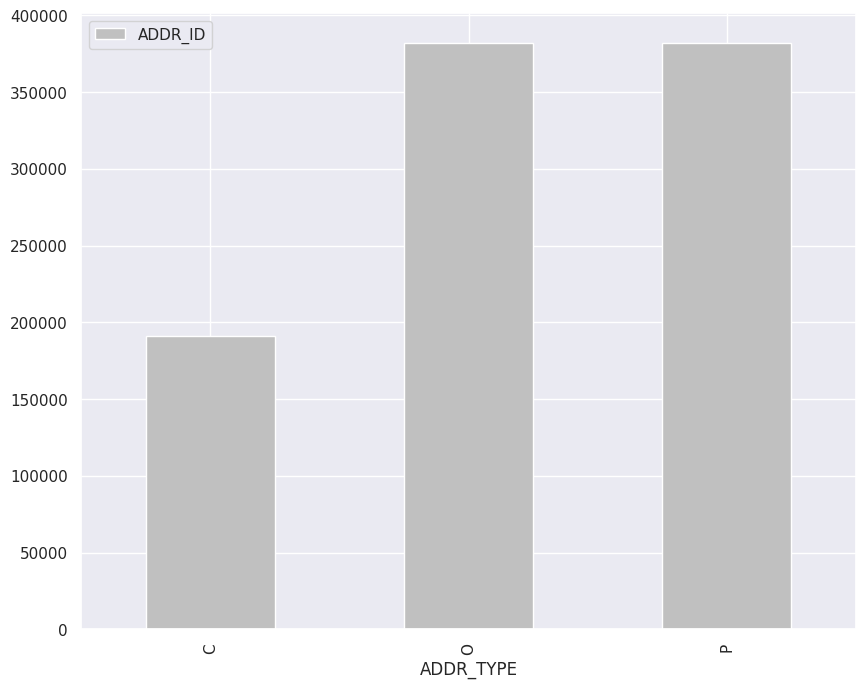

In [42]:
s = countBy('ADDR_ID', 'ADDR_TYPE', res)
# vysledek je pandas "serie", kterou muzeme vizualizovat pomoci bar plot
s.plot.bar(color='silver')
plt.show()

In [43]:
# pocet chybejicich pozorovani
res['ADDR_TYPE'].isnull().sum()

0

#### ADDR_COUNTRY

In [44]:
# frekvencni analyza
countBy('ADDR_ID', 'ADDR_COUNTRY', res)

,ADDR_ID
ADDR_COUNTRY,
CZE,955217


In [45]:
# pocet chybejicich pozorovani
res['ADDR_COUNTRY'].isnull().sum()

0

#### ADDR_CITY

In [46]:
countBy('ADDR_ID', 'ADDR_CITY', res).head()

,ADDR_ID
ADDR_CITY,
,966
,1
A3,1
ABERTAMY,34
ADAMOV,89


In [47]:
# pattern analysis
asc, desc = getPatterns('ADDR_CITY', res)

In [36]:
asc[0:10]

[('Aaaaaa#*#Aaaaaa#', 1),
 ('AAAAAA#AAA#AAAAAAAA#', 1),
 ('Aaaa#Aa9aaa', 1),
 ('Aaaaaaa#aa#Aaaaaa#', 1),
 ('Aaaaaaa#aaa#Aaaaaa9#*#Aaaaaa', 1),
 ('Aaaaa*Aaaa9a', 1),
 ('Aaaaa#aaa#Aaaaaaa#*#Aaaa9#Aaaaa', 1),
 ('Aaaaa#*#Aaa9aaaaa', 1),
 ('Aaaaa9ťaaa', 1),
 ('Aaaaaa#Aaaaaaa#*#Aaaaa9', 1)]

In [37]:
# pocet chybejicich pozorovani
res['ADDR_CITY'].isnull().sum()

0

#### ADDR_ZIP

In [48]:
# pattern analysis
asc, desc = getPatterns('ADDR_ZIP', res)

In [49]:
# 10 nejmene castych vzoru
asc[0:10]

[('', 958), ('999#9', 19016), ('99999', 935243)]

In [50]:
# 10 nejcastejcisch vzoru
desc[0:10]

[('99999', 935243), ('999#9', 19016), ('', 958)]

In [51]:
# pocet NULL pozorovani ... neni to same co prazdne!!!
res['ADDR_ZIP'].isnull().sum()

0

#### ADDR_STREET

In [52]:
countBy('ADDR_ID', 'ADDR_STREET', res).head()

,ADDR_ID
ADDR_STREET,
1,6443
1. května 234,1
1. máje 35,1
1. KVĚTNA 768/20,4
1. MÁJE 1038,4


In [53]:
# pattern analysis
asc, desc = getPatterns('ADDR_STREET', res)

In [45]:
asc[0:10]

[('Aaaaaaaaa##aaaaa##999*99', 1),
 ('A##aaaa##aaaaa##9999', 1),
 ('Aaaa$aaa#999', 1),
 ('Aaaa$aa#999', 1),
 ('Aaaaaaa##aa*##999*999', 1),
 ('Aaaaa$aa#9999*9', 1),
 ('A##Aaaaaaaa##99', 1),
 ('Aaaaaaaa##aaaa##999', 1),
 ('AAAAAA##9999', 1),
 ('Aaaaa##999##*##99', 1)]

In [46]:
# pocet chybejicich pozorovani
res['ADDR_STREET'].isnull().sum()

0

#### ADDR_NUM1

In [47]:
countBy('ADDR_ID', 'ADDR_NUM1', res).head()

,ADDR_ID
ADDR_NUM1,


In [48]:
# pattern analysis
asc, desc = getPatterns('ADDR_NUM1', res)
asc[0:10]

[('Aaaa', 955217)]

In [49]:
# pocet chybejicich pozorovani
res['ADDR_NUM1'].isnull().sum()

955217

... takže to je NULL a Python encodoval Null jako Aaaa vzor

#### ADDR_NUM2

In [50]:
countBy('ADDR_ID', 'ADDR_NUM2', res).head()

,ADDR_ID
ADDR_NUM2,


In [51]:
res['ADDR_NUM2'].isnull().sum()

955217

## Profilace klientu

In [54]:
# load adres z MySQL
res = query('select * from PART_PARTY')

In [53]:
res.head()

,PARTY_ID,PARTY_TYPE,PARTY_FNAME,PARTY_LNAME,PARTY_NAME,PARTY_FORM,PARTY_CREGNUM,PARTY_RC,PARTY_COUNTRY,PARTY_POFBIRTH,PARTY_AGE,PARTY_GENDER,PARTY_DOFBIRTH,PARTY_TITBEF,PARTY_TITAFT,PARTY_ESA95,PARTY_OKEC,PARTY_SINCE
0,1,P,ERDENETUYA,KOVÁČOVÁ,,NaN,None,9999999999,CZE,Praha,80.0,F,1932-08-15,None,None,NaN,None,2011-06-22
1,2,P,VALTER,NĚMEC,,NaN,None,320815621,CZE,Praha,80.0,M,1932-08-15,None,None,NaN,None,2010-11-24
2,3,P,ELENA,STRNADOVA,,NaN,None,325815553,CZE,Praha,80.0,F,1932-08-15,None,None,NaN,None,2010-02-03
3,4,P,HASMIK,ŠULCOVÁ,,NaN,None,325815000,CZE,Praha,80.0,F,1932-08-15,None,None,NaN,None,2010-02-01
4,5,P,LUISA,HOLUBOVÁ,,NaN,None,325814030,CZE,Praha,80.0,F,1932-08-14,None,None,NaN,None,2010-02-02


In [54]:
res.dtypes

PARTY_ID            int64
PARTY_TYPE         object
PARTY_FNAME        object
PARTY_LNAME        object
PARTY_NAME         object
PARTY_FORM        float64
PARTY_CREGNUM      object
PARTY_RC           object
PARTY_COUNTRY      object
PARTY_POFBIRTH     object
PARTY_AGE         float64
PARTY_GENDER       object
PARTY_DOFBIRTH     object
PARTY_TITBEF       object
PARTY_TITAFT       object
PARTY_ESA95       float64
PARTY_OKEC         object
PARTY_SINCE        object
dtype: object

In [55]:
res.describe()

,PARTY_ID,PARTY_FORM,PARTY_AGE,PARTY_ESA95
count,383131.00000,111101.000000,261101.000000,1.193480e+05
mean,191566.00000,6.649328,45.661208,1.929869e+04
std,110600.53733,12.083348,18.499126,4.780647e+05
min,1.00000,1.000000,15.000000,1.100100e+04
25%,95783.50000,1.000000,30.000000,1.420000e+04
50%,191566.00000,1.000000,44.000000,1.420000e+04
75%,287348.50000,7.000000,60.000000,1.420000e+04
max,383131.00000,64.000000,98.000000,4.962662e+07


#### PARTY_TYPE

In [56]:
countBy('PARTY_ID', 'PARTY_TYPE', res).head()

,PARTY_ID
PARTY_TYPE,
C,119348
P,263783


In [57]:
res['PARTY_TYPE'].isnull().sum()

0

#### PARTY_FNAME

In [58]:
countBy('PARTY_ID', 'PARTY_FNAME', res).head()

,PARTY_ID
PARTY_FNAME,
-,46
A A R O N,9
A B B A S,5
A B D A L L A H,7
A B D E L K A D E R,7


In [59]:
# pattern analysis
asc, desc = getPatterns('PARTY_FNAME', res)
asc[0:10]

[('A#A#Ť#A#A#A#A##', 1),
 ('A#A#A#*#A#A#A#A#A#A', 1),
 ('A#Ä#A#A#A#A#', 2),
 ('A#Ą#A#A#', 2),
 ('A#A#A#A#A#A###A#A#A##', 2),
 ('A#A#A###A#A#A#A#A#A#', 2),
 ('A#Ű#A#A#A#A#', 2),
 ('Ą#A#A#A#A#A##', 2),
 ('A#Ó#A#A#A#', 2),
 ('A#A#A###A#A#A#A#A#A#A#A#A#', 2)]

In [60]:
res['PARTY_FNAME'].isnull().sum()

0

In [61]:
desc[0:10]

[('AA', 120661),
 ('AAAAAA', 40577),
 ('AAAAA', 39131),
 ('AAAAAAA', 34473),
 ('AAAAAAAA', 23857),
 ('AAAA', 22539),
 ('AAAAAAAAA', 13380),
 ('AAA', 7959),
 ('AAAAAAAAAA', 5864),
 ('AAA#AAAA', 5719)]

... to vypadá jako že nejčetnější je něco jako "NA"

#### PARTY_LNAME

In [62]:
countBy('PARTY_ID', 'PARTY_LNAME', res).head()

,PARTY_ID
PARTY_LNAME,
ADAMCOVA,39
ADAMCOVÁ,652
ADAMEC,471
ADAMEK,30
ADAMKOVA,35


In [63]:
# pattern analysis
asc, desc = getPatterns('PARTY_LNAME', res)
asc[0:10]

[('AA9A', 60),
 ('AA9AAAA', 68),
 ('AA9AAAAA', 68),
 ('AÜAAA', 117),
 ('AÜAAAA', 134),
 ('AAAAA9A', 135),
 ('AA9AAA', 157),
 ('AÜAAAAAAA', 162),
 ('AAAA9A', 168),
 ('AÜAAAAAA', 181)]

In [64]:
res['PARTY_FNAME'].isnull().sum()

0

In [65]:
desc[0:10]

[('AA', 119824),
 ('AAAAAAA', 58672),
 ('AAAAAAAA', 45914),
 ('AAAAAAAAA', 42742),
 ('AAAAA', 40236),
 ('AAAAAA', 32147),
 ('AAAAAAAAAA', 18229),
 ('AAAA', 12401),
 ('AAAAAAAAAAA', 4926),
 ('AAŇAAAA', 1202)]

#### PARTY_NAME

In [66]:
countBy('PARTY_ID', 'PARTY_NAME', res).head()

,PARTY_ID
PARTY_NAME,
,263783
+MBS+ AUTOSLUŽBA MĚLNÍK s.r.o.,3
001 dovolená Online,1
01-Koksovna Svoboda Ostrava-Přívoz,2
01-ZO OS PHGN Dolu Centrum Dolní Jiřetín,2


In [67]:
res['PARTY_NAME'].isnull().sum()

0

In [68]:
countBy('PARTY_ID', 'PARTY_TYPE', res).head()

,PARTY_ID
PARTY_TYPE,
C,119348
P,263783


#### PARTY_FORM

In [69]:
countBy('PARTY_ID', 'PARTY_FORM', res).head()

,PARTY_ID
PARTY_FORM,
1.0,74384
2.0,775
3.0,3095
5.0,4517
6.0,3


In [70]:
res['PARTY_FORM'].isnull().sum()

272030

#### PARTY_CREGNUM

In [71]:
res['PARTY_CREGNUM'].isnull().sum()

263783

In [72]:
# pattern analysis
asc, desc = getPatterns('PARTY_CREGNUM', res)
asc[0:10]

[('99999999', 119348), ('Aaaa', 263783)]

#### PARTY_RC

In [73]:
res['PARTY_RC'].isnull().sum()

114723

In [74]:
# pattern analysis
asc, desc = getPatterns('PARTY_RC', res)
asc[0:10]

[('AAAAAAA', 2633),
 ('AAAA', 3669),
 ('AAAAAAAAAA', 3726),
 ('#', 6192),
 ('999999999#', 25445),
 ('999999999', 42933),
 ('Aaaa', 114723),
 ('9999999999', 183810)]

#### PARTY_COUNTRY

In [75]:
countBy('PARTY_ID', 'PARTY_COUNTRY', res)

,PARTY_ID
PARTY_COUNTRY,
CZE,383131


In [76]:
res['PARTY_COUNTRY'].isnull().sum()

0

#### PARTY_POFBIRTH

In [77]:
countBy('PARTY_ID', 'PARTY_POFBIRTH', res)

,PARTY_ID
PARTY_POFBIRTH,
Praha,263783


In [78]:
res['PARTY_POFBIRTH'].isnull().sum()

119348

#### PARTY_AGE

In [79]:
res['PARTY_AGE'].isnull().sum()

122030

#### PARTY_GENDER

In [80]:
countBy('PARTY_ID', 'PARTY_GENDER', res)

,PARTY_ID
PARTY_GENDER,
F,150905
M,107550


In [81]:
res['PARTY_GENDER'].isnull().sum()

124676

In [82]:
countBy('PARTY_ID', 'PARTY_TYPE', res)

,PARTY_ID
PARTY_TYPE,
C,119348
P,263783


### PARTY_DOFBIRTH

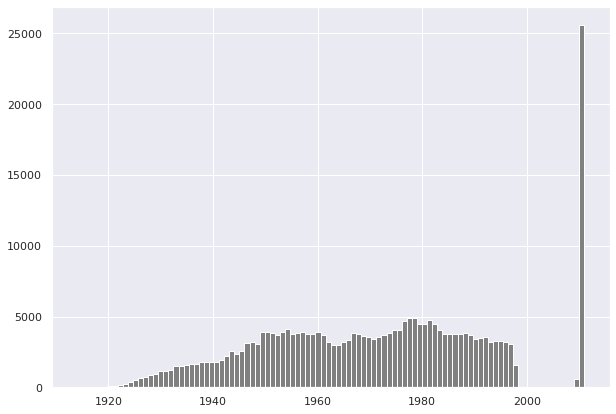

In [83]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
res['PARTY_DOFBIRTH'].hist(bins=100, color='gray', edgecolor='white')
plt.show()

#### PARTY_TITBEF

In [84]:
countBy('PARTY_ID', 'PARTY_TITBEF', res)

,PARTY_ID
PARTY_TITBEF,
Bc,2152
Bc.,2169
Dr.,2167
ING.,2185
Ing,2359
Ing.,2122
MUDr,2285
Mgr,2235
Mgr.,2078


In [85]:
res['PARTY_TITBEF'].isnull().sum()

339170

#### PARTY_TITAFT

In [86]:
countBy('PARTY_ID', 'PARTY_TITAFT', res)

,PARTY_ID
PARTY_TITAFT,
CsC,2268
Csc,2158
DrS,2132
MBA,2305
PhD,2190


#### PARTY_ESA95

In [87]:
countBy('PARTY_ID', 'PARTY_ESA95', res).head()

,PARTY_ID
PARTY_ESA95,
11001.0,153
11002.0,11263
11003.0,7052
12201.0,2
12202.0,10


#### PARTY_OKEC

In [88]:
countBy('PARTY_ID', 'PARTY_OKEC', res)

,PARTY_ID
PARTY_OKEC,


#### PARTY_SINCE

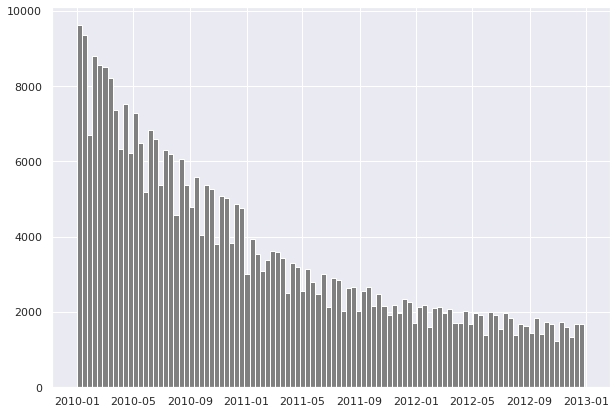

In [89]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
res['PARTY_SINCE'].hist(bins=100, color='gray', edgecolor='white')
plt.show()

In [90]:
res['PARTY_SINCE'].isnull().sum()

26876

### PARTY_CONTACT

In [91]:
# load adres z MySQL
res = query('select * from PARTY_CONTACT')

In [92]:
res.dtypes

CONT_ID              int64
PARTY_ID             int64
CONT_TYPE           object
CONT_PRIMARY_FLG    object
CONT_VALUE          object
dtype: object

In [93]:
res.describe()

,CONT_ID,PARTY_ID
count,529815.000000,529815.000000
mean,264908.000000,220238.487744
std,152944.560773,119904.442729
min,1.000000,1.000000
25%,132454.500000,129522.000000
50%,264908.000000,234456.000000
75%,397361.500000,332421.000000
max,529815.000000,421010.000000


#### CONT_TYPE

In [94]:
countBy('CONT_ID', 'CONT_TYPE', res)

,CONT_ID
CONT_TYPE,
E,228153
M,301662


In [95]:
res['CONT_TYPE'].isnull().sum()

0

#### CONT_PRIMARY_FLG

In [96]:
countBy('CONT_ID', 'CONT_PRIMARY_FLG', res)

,CONT_ID
CONT_PRIMARY_FLG,


#### CONT_VALUE

In [97]:
# pattern analysis
asc, desc = getPatterns('CONT_VALUE', res)
asc[0:10]

[('aaaaa*aaaaaa_aťaaaaa#aaaaaa&aa', 1),
 ('aaaaaaaaa#aaaaa*aaaaaa@aaaaa*aaa', 1),
 ('aaa#aaaaa#aaaa#aaaaa&aa', 1),
 ('aaaaaaaaaaa#aaaa@aaaaaa*aa', 1),
 ('aaaaał*aaaaaa@aaaaa*aaa', 1),
 ('aaaaaaa_aaaaa#aaa#aaaaa&aaa', 1),
 ('aaaaa#aaaaaaa_aaaaaaa#aaaaa&aaa', 1),
 ('aaa#aaa#aa&aaaaaaaaaa#aaaaaa&aa', 1),
 ('aaaaaaa#aaa@aaaaaaa*aa', 1),
 ('aa#aa*aaaaaaaaaaa@aaaaa*aaa', 1)]

In [98]:
asc, desc = getPatterns('CONT_VALUE', res[res['CONT_TYPE'] == 'M'])
asc[0:10]

[('9999999999', 29291), ('999999999', 272371)]

In [99]:
asc, desc = getPatterns('CONT_VALUE', res[res['CONT_TYPE'] == 'E'])
asc[0:10]

[('aaaaa*aaaaaa_aťaaaaa#aaaaaa&aa', 1),
 ('aaaaaaaaa#aaaaa*aaaaaa@aaaaa*aaa', 1),
 ('aaa#aaaaa#aaaa#aaaaa&aa', 1),
 ('aaaaaaaaaaa#aaaa@aaaaaa*aa', 1),
 ('aaaaał*aaaaaa@aaaaa*aaa', 1),
 ('aaaaaaa_aaaaa#aaa#aaaaa&aaa', 1),
 ('aaaaa#aaaaaaa_aaaaaaa#aaaaa&aaa', 1),
 ('aaa#aaa#aa&aaaaaaaaaa#aaaaaa&aa', 1),
 ('aaaaaaa#aaa@aaaaaaa*aa', 1),
 ('aa#aa*aaaaaaaaaaa@aaaaa*aaa', 1)]

### PROD_CONTRACT

In [100]:
# load adres z MySQL
res = query('select * from PROD_CONTRACT')

In [101]:
res.dtypes

CNTR_ID            int64
PARTY_ID           int64
PRODUCT_CODE      object
CNTR_VALIDFROM    object
CNTR_VALIDTO      object
CNTR_CANCTYPE     object
CNTR_PAY_FREQ      int64
dtype: object

In [102]:
countBy('CNTR_ID', 'PRODUCT_CODE', res).head()

,CNTR_ID
PRODUCT_CODE,
DO1,34249
DO2,33951
DO3,34092
HA1,53291
HA2,53793


In [103]:
res['PRODUCT_CODE'].isnull().sum()

0

In [104]:
res['CNTR_VALIDFROM'].isnull().sum()

0

In [105]:
res['CNTR_VALIDTO'].isnull().sum()

0

In [106]:
countBy('CNTR_ID', 'CNTR_PAY_FREQ', res)

,CNTR_ID
CNTR_PAY_FREQ,
0,46074
1,191000
2,252589
3,46883
4,93105
5,44810
12,268988
